In [2]:
import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
from qiskit import Aer
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import multiprocessing as mp

import sys
sys.path.insert(0, '../../src/')
from neuralnetwork import *
from analysis import *
from utils import *

#%matplotlib notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
def parallel_fit(args):
    tl = args[0]
    x = args[1]
    
    tl.fit(x)
    
    return tl

def parallel_train(args):
    model = args[0]
    x = args[1]
    y = args[2]
    verbose = args[3]
    
    model.train(x, y, epochs=5, verbose = verbose)
    
    return [model, x, y, verbose]

def average_loss(network_list):
    loss = [network[0].loss[-1] for network in network_list]
    loss = sum(loss)/len(loss)
    
    return loss

# Expressivity of QCN vs DNN

## Node Expressivity

In [14]:
x_qnn = np.linspace(-np.pi/2, np.pi/2, 100).reshape(-1,1)
x_qnn_stacked = np.hstack([x_qnn,x_qnn,x_qnn,x_qnn])

x_dnn = 3*x_qnn_stacked

In [15]:
np.random.seed(42)
qnn_1_list = []
qnn_4_list = []
qnn_8_list = []
dnn_list = []
for i in range(5):    
    qnn_1 = sequential_qnn(n_qubits = [4],
                          dim = [1,1],
                          encoder = Encoder(),
                          ansatz = Ansatz(blocks=["entangle", "ry"], reps=2),
                          sampler = Parity(),
                          shots = 0)
    
    qnn_4 = sequential_qnn(n_qubits = [4],
                         dim = [4,1],
                         encoder = Encoder(),
                         ansatz = Ansatz(blocks=["entangle", "ry"], reps=2),
                         sampler = Parity(),
                         shots = 0)
    
    qnn_8 = sequential_qnn(n_qubits = [8],
                         dim = [8,1],
                         encoder = Encoder(),
                         ansatz = Ansatz(blocks=["entangle", "ry"], reps=2),
                         sampler = Parity(),
                         shots = 0)
    
    
    dnn = sequential_dnn(dim = [4,1])
    
    qnn_1_list.append(qnn_1)
    qnn_4_list.append(qnn_4)
    qnn_8_list.append(qnn_8)
    dnn_list.append(dnn)    

In [16]:
y_pred_qnn_1 = [qnn.predict(x_qnn) for qnn in qnn_1_list]

In [17]:
y_pred_qnn_4 = [qnn.predict(x_qnn_stacked) for qnn in qnn_4_list]

In [18]:
y_pred_qnn_8 = [qnn.predict(x_qnn_stacked) for qnn in qnn_8_list]

In [19]:
y_pred_dnn = [dnn.predict(x_dnn) for dnn in dnn_list]

### Plot

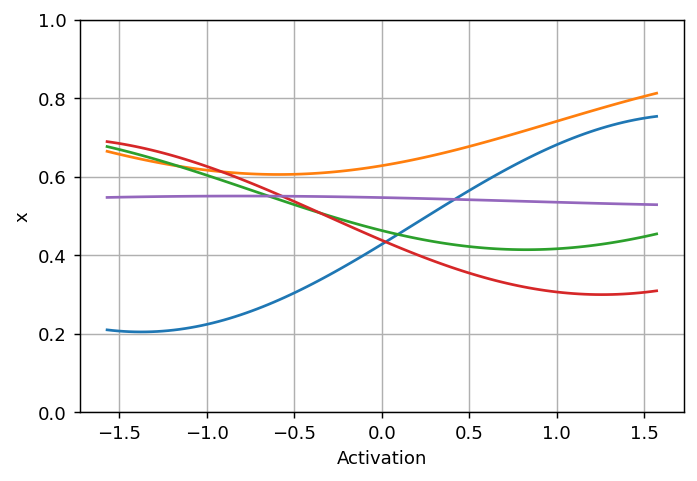

In [20]:
fig=plt.figure(figsize=(6,4), dpi = 130, facecolor='w', edgecolor='k')
plt.plot(x_qnn, y_pred_qnn_1[0])
plt.plot(x_qnn, y_pred_qnn_1[1])
plt.plot(x_qnn, y_pred_qnn_1[2])
plt.plot(x_qnn, y_pred_qnn_1[3])
plt.plot(x_qnn, y_pred_qnn_1[4])
plt.xlabel("Activation")
plt.ylabel("x")
plt.grid()
plt.ylim([0,1])
fig.savefig(image_path("activation_qnn_1.pdf"), bbox_inches='tight')
plt.show()

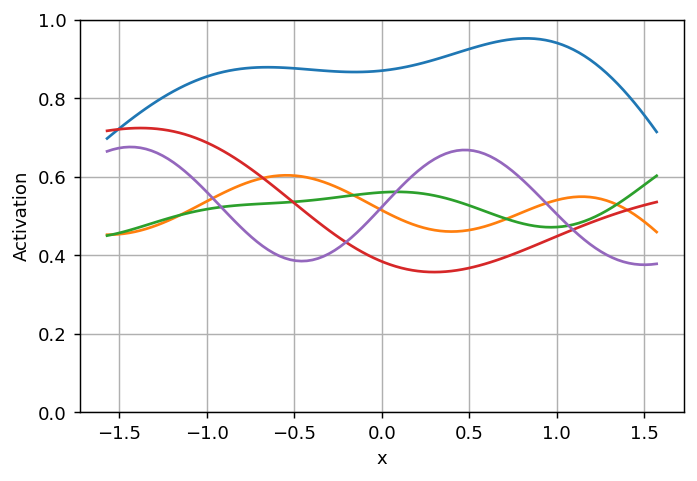

In [21]:
fig=plt.figure(figsize=(6,4), dpi = 130, facecolor='w', edgecolor='k')
plt.plot(x_qnn, y_pred_qnn_4[0])
plt.plot(x_qnn, y_pred_qnn_4[1])
plt.plot(x_qnn, y_pred_qnn_4[2])
plt.plot(x_qnn, y_pred_qnn_4[3])
plt.plot(x_qnn, y_pred_qnn_4[4])
plt.ylabel("Activation")
plt.xlabel("x")
plt.grid()
plt.ylim([0,1])
fig.savefig(image_path("activation_qnn_4.pdf"), bbox_inches='tight')
plt.show()

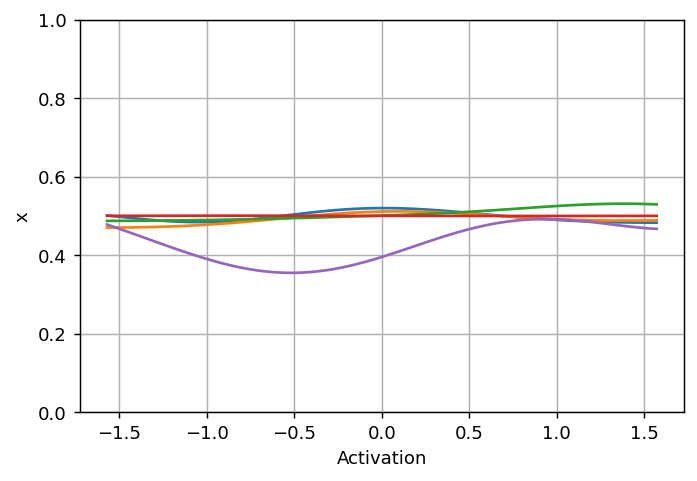

In [12]:
fig=plt.figure(figsize=(6,4), dpi = 130, facecolor='w', edgecolor='k')
plt.plot(x_qnn, y_pred_qnn_8[0])
plt.plot(x_qnn, y_pred_qnn_8[1])
plt.plot(x_qnn, y_pred_qnn_8[2])
plt.plot(x_qnn, y_pred_qnn_8[3])
plt.plot(x_qnn, y_pred_qnn_8[4])
plt.ylabel("Activation")
plt.xlabel("x")
plt.grid()
plt.ylim([0,1])
fig.savefig(image_path("activation_qnn_8.pdf"), bbox_inches='tight')
plt.show()

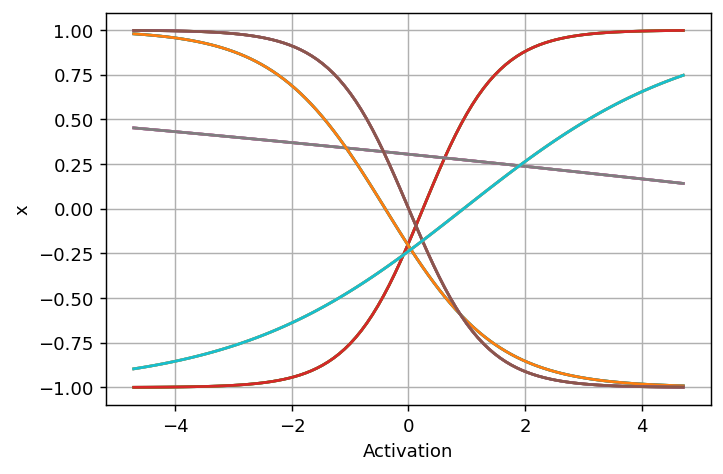

In [13]:
fig=plt.figure(figsize=(6,4), dpi = 130, facecolor='w', edgecolor='k')
plt.plot(x_dnn, y_pred_dnn[0])
plt.plot(x_dnn, y_pred_dnn[1])
plt.plot(x_dnn, y_pred_dnn[2])
plt.plot(x_dnn, y_pred_dnn[3])
plt.plot(x_dnn, y_pred_dnn[4])
plt.ylabel("Activation")
plt.xlabel("x")
plt.grid()
fig.savefig(image_path("activation_dnn.pdf"), bbox_inches='tight')
plt.show()

## Trajectory Length

In [4]:
theta = np.linspace(0, 2*np.pi, 1000)
theta = np.append(theta, theta[0:1]).reshape(-1,1)

x1 = np.pi*np.cos(theta)/2
x2 = np.pi*np.sin(theta)/2
x_qcn = np.hstack([x1, x2])
x_dnn = scaler(x_qcn, mode="standard")

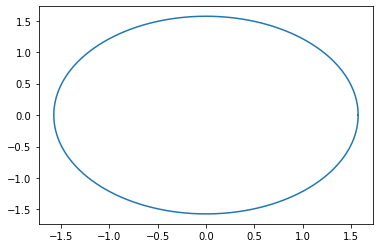

In [5]:
plt.plot(x_qcn[:,0], x_qcn[:,1])
plt.show()

## Random Initialization

### QCN

In [9]:
np.random.seed(42)

tl_list = []
for i in range(10):
    qcn = sequential_qnn(n_qubits = 8*[4],
                             dim = [2] + *[4],
                             scale = 8*[[-np.pi, np.pi]],
                             encoder = Encoder(),
                             ansatz = Ansatz(blocks=["entangle", "ry"], reps=2),
                             sampler = Parity(),
                             shots = 0)


    tl = TrajectoryLength(qcn)
    tl_list.append([tl, x_qcn])

print(qcn.n_parameters)

7


In [ ]:
with mp.Pool(10) as p:
    tl_list = p.map(parallel_fit, tl_list)
    
saver(tl_list, data_path("tl_expressivity_width_4_reps_2"))

In [18]:
np.random.seed(42)

tl_list = []
for i in range(10):
    qcn = sequential_qnn(n_qubits = 8*[5],
                             dim = [5] + 7*[5],
                             scale = 8*[[-np.pi, np.pi]],
                             encoder = Encoder(),
                             ansatz = Ansatz(blocks=["entangle", "ry"], reps=2),
                             sampler = Parity(),
                             shots = 0)


    tl = TrajectoryLength(qcn)
    tl_list.append([tl, x_qcn])

print(qcn.n_parameters)

350


In [ ]:
with mp.Pool(10) as p:
    tl_list = p.map(parallel_fit, tl_list)
    
saver(tl_list, data_path("tl_expressivity_width_5_reps_2"))

In [19]:
np.random.seed(42)

tl_list = []
for i in range(10):
    qcn = sequential_qnn(n_qubits = 8*[6],
                             dim = [2] + 7*[6],
                             scale = 8*[[-np.pi, np.pi]],
                             encoder = Encoder(),
                             ansatz = Ansatz(blocks=["entangle", "ry"], reps=2),
                             sampler = Parity(),
                             shots = 0)


    tl = TrajectoryLength(qcn)
    tl_list.append([tl, x_qcn])

print(qcn.n_parameters)

504


In [ ]:
with mp.Pool(10) as p:
    tl_list = p.map(parallel_fit, tl_list)
    
saver(tl_list, data_path("tl_expressivity_width_6_reps_2"))

In [20]:
np.random.seed(42)

tl_list = []
for i in range(10):
    qcn = sequential_qnn(n_qubits = 8*[7],
                             dim = [2] + 7*[7],
                             scale = 8*[[-np.pi, np.pi]],
                             encoder = Encoder(),
                             ansatz = Ansatz(blocks=["entangle", "ry"], reps=2),
                             sampler = Parity(),
                             shots = 0)


    tl = TrajectoryLength(qcn)
    tl_list.append([tl, x_qcn])

print(qcn.n_parameters)

686


In [ ]:
with mp.Pool(10) as p:
    tl_list = p.map(parallel_fit, tl_list)
    
saver(tl_list, data_path("tl_expressivity_width_7_reps_2"))

In [21]:
np.random.seed(42)

tl_list = []
for i in range(10):
    qcn = sequential_qnn(n_qubits = 8*[8],
                             dim = [2] + 7*[8],
                             scale = 8*[[-np.pi, np.pi]],
                             encoder = Encoder(),
                             ansatz = Ansatz(blocks=["entangle", "ry"], reps=2),
                             sampler = Parity(),
                             shots = 0)


    tl = TrajectoryLength(qcn)
    tl_list.append([tl, x_qcn])

print(qcn.n_parameters)

896


In [ ]:
with mp.Pool(10) as p:
    tl_list = p.map(parallel_fit, tl_list)
    
saver(tl_list, data_path("tl_expressivity_width_8_reps_2"))

### DNN

In [25]:
np.random.seed(42)

tl_list = []
for i in range(10):
    dnn = sequential_dnn(dim=[2] + 7*[11])


    tl = TrajectoryLength(dnn)
    tl_list.append([tl, x_dnn])

print(dnn.n_parameters)
    
with mp.Pool(10) as p:
    tl_list = p.map(parallel_fit, tl_list)

saver(tl_list, data_path("tl_expressivity_dnn"))

825


## Training

In [26]:
np.random.seed(42)

n = 12
x = np.linspace(0, 1, n)
x = generate_meshgrid([x,x])

mean1 = np.array([[0.2, 0.8]])
var1 = np.array([[0.01, 0], [0, 0.01]])

mean2 = np.array([[0.5, 0.8]])
var2 = np.array([[0.01, 0], [0, 0.01]])

mean3 = np.array([[0.8, 0.8]])
var3 = np.array([[0.01, 0], [0, 0.01]])

mean4 = np.array([[0.2, 0.5]])
var4 = np.array([[0.01, 0], [0, 0.01]])

mean5 = np.array([[0.5, 0.5]])
var5 = np.array([[0.01, 0], [0, 0.01]])

mean6 = np.array([[0.8, 0.5]])
var6 = np.array([[0.01, 0], [0, 0.01]])

mean7 = np.array([[0.2, 0.2]])
var7 = np.array([[0.01, 0], [0, 0.01]])

mean8 = np.array([[0.5, 0.2]])
var8 = np.array([[0.01, 0], [0, 0.01]])

mean9 = np.array([[0.8, 0.2]])
var9 = np.array([[0.01, 0], [0, 0.01]])


y = gaussian(x, mean1, var1) - gaussian(x, mean2, var2) + gaussian(x, mean3, var3) - gaussian(x, mean4, var4) +\
gaussian(x, mean5, var5) - gaussian(x, mean6, var6) + gaussian(x, mean7, var7) - gaussian(x, mean8, var8) +\
gaussian(x, mean9, var9)


x_train_qcn = scaler(x, a=-np.pi/2, b=np.pi/2)
x_train_dnn = scaler(x, mode="standard")
y = scaler(y, a=0, b=1)

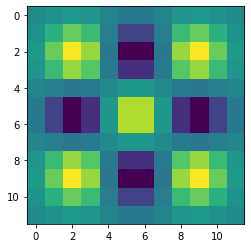

In [27]:
plt.imshow(y.reshape(n,n))
plt.show()

## QCN

## 6 Qubits

In [29]:
np.random.seed(42)

qcn_list = []
for i in range(10):
    qcn = sequential_qnn(n_qubits = [6, 6, 6, 6],
                         dim = [2, 6, 6, 6, 1] ,
                         scale = 3*[[-np.pi, np.pi]] + [[0,1]],
                         encoder = Encoder(),
                         ansatz = Ansatz(blocks=["entangle", "ry"], reps=2),
                         sampler = Parity(),
                         shots = 0,
                         optimizer=Adam(lr=0.1))
    
    qcn_list.append([qcn, x_train_qcn, y, False])

    
qcn_list[0][3] = True
print(qcn_list[0][0].n_parameters)

saver(qcn_list, data_path("network_expressivity_qubit_6_epochs_0"))

228


#### Train Incrementally

In [72]:
#qcn_list = loader(data_path("network_expressivity_qubit_6_epochs_0"))
with mp.Pool(10) as p:
    qcn_list = p.map(parallel_train, qcn_list)
    
saver(qcn_list, data_path("network_expressivity_qubit_6_epochs_5"))

epoch: 0, loss: 0.05654377988058121
epoch: 1, loss: 0.0972733490024423
epoch: 2, loss: 0.05657048847353399
epoch: 3, loss: 0.05031032560070944
epoch: 4, loss: 0.04694753915535017


In [41]:
qcn_list = loader(data_path("network_expressivity_qubit_6_epochs_5"))
print(average_loss(qcn_list))

0.04521848635951677


In [73]:
with mp.Pool(10) as p:
    qcn_list = p.map(parallel_train, qcn_list)
    
saver(qcn_list, data_path("network_expressivity_qubit_6_epochs_10"))

epoch: 0, loss: 0.0452744838285783
epoch: 1, loss: 0.045250080065307605
epoch: 2, loss: 0.04269749947982572
epoch: 3, loss: 0.040177393739772665
epoch: 4, loss: 0.036593338274931525


In [42]:
qcn_list = loader(data_path("network_expressivity_qubit_6_epochs_10"))
print(average_loss(qcn_list))

0.02902923578679978


In [74]:
with mp.Pool(10) as p:
    qcn_list = p.map(parallel_train, qcn_list)
    
saver(qcn_list, data_path("network_expressivity_qubit_6_epochs_15"))

epoch: 0, loss: 0.03475627989018616
epoch: 1, loss: 0.03456850521433748
epoch: 2, loss: 0.03180785494819913
epoch: 3, loss: 0.030148350953935518
epoch: 4, loss: 0.028895244601856607


In [43]:
qcn_list = loader(data_path("network_expressivity_qubit_6_epochs_15"))
print(average_loss(qcn_list))

0.020919204540285882


In [75]:
with mp.Pool(10) as p:
    qcn_list = p.map(parallel_train, qcn_list)
    
saver(qcn_list, data_path("network_expressivity_qubit_6_epochs_20"))

epoch: 0, loss: 0.02749442679033217
epoch: 1, loss: 0.027417358158640735
epoch: 2, loss: 0.0295206173147267
epoch: 3, loss: 0.026663514786300926
epoch: 4, loss: 0.023664468825625957


In [44]:
qcn_list = loader(data_path("network_expressivity_qubit_6_epochs_20"))
print(average_loss(qcn_list)) 

0.01622510431548737


In [81]:
with mp.Pool(10) as p:
    qcn_list = p.map(parallel_train, qcn_list)
    
saver(qcn_list, data_path("network_expressivity_qubit_6_epochs_25"))

epoch: 0, loss: 0.0249272444138415
epoch: 1, loss: 0.022233104905751325
epoch: 2, loss: 0.02018659609648645
epoch: 3, loss: 0.019993330091378228
epoch: 4, loss: 0.01791452433879763


In [45]:
qcn_list = loader(data_path("network_expressivity_qubit_6_epochs_25"))
print(average_loss(qcn_list)) 

0.012324969577849995


In [82]:
with mp.Pool(10) as p:
    qcn_list = p.map(parallel_train, qcn_list)
    
saver(qcn_list, data_path("network_expressivity_qubit_6_epochs_30"))

epoch: 0, loss: 0.016563952318098634
epoch: 1, loss: 0.01578101185626488
epoch: 2, loss: 0.014963159944658652
epoch: 3, loss: 0.015624311526258823
epoch: 4, loss: 0.012766855338178286


#### Calculate Trajectory

In [76]:
qcn_list = loader(data_path("network_expressivity_qubit_6_epochs_0"))
tl_list = []
for qcn in qcn_list:
    tl = TrajectoryLength(qcn[0])
    tl_list.append([tl, x_qcn])

with mp.Pool(10) as p:
    tl_list = p.map(parallel_fit, tl_list)
    
saver(tl_list, data_path("tl_expressivity_qubit_6_epochs_0"))

In [77]:
qcn_list = loader(data_path("network_expressivity_qubit_6_epochs_5"))
tl_list = []
for qcn in qcn_list:
    tl = TrajectoryLength(qcn[0])
    tl_list.append([tl, x_qcn])

with mp.Pool(10) as p:
    tl_list = p.map(parallel_fit, tl_list)
    
saver(tl_list, data_path("tl_expressivity_qubit_6_epochs_5"))

In [78]:
qcn_list = loader(data_path("network_expressivity_qubit_6_epochs_10"))
tl_list = []
for qcn in qcn_list:
    tl = TrajectoryLength(qcn[0])
    tl_list.append([tl, x_qcn])

with mp.Pool(10) as p:
    tl_list = p.map(parallel_fit, tl_list)
    
saver(tl_list, data_path("tl_expressivity_qubit_6_epochs_10"))

In [79]:
qcn_list = loader(data_path("network_expressivity_qubit_6_epochs_15"))
tl_list = []
for qcn in qcn_list:
    tl = TrajectoryLength(qcn[0])
    tl_list.append([tl, x_qcn])

with mp.Pool(10) as p:
    tl_list = p.map(parallel_fit, tl_list)
    
saver(tl_list, data_path("tl_expressivity_qubit_6_epochs_15"))

In [80]:
qcn_list = loader(data_path("network_expressivity_qubit_6_epochs_20"))
tl_list = []
for qcn in qcn_list:
    tl = TrajectoryLength(qcn[0])
    tl_list.append([tl, x_qcn])

with mp.Pool(10) as p:
    tl_list = p.map(parallel_fit, tl_list)
    
saver(tl_list, data_path("tl_expressivity_qubit_6_epochs_20"))

## 7 Qubits

In [30]:
np.random.seed(42)

qcn_list = []
for i in range(10):
    qcn = sequential_qnn(n_qubits = [7, 7, 7, 7],
                         dim = [2, 7, 7, 7, 1] ,
                         scale = 3*[[-np.pi, np.pi]] + [[0,1]],
                         encoder = Encoder(),
                         ansatz = Ansatz(blocks=["entangle", "ry"], reps=2),
                         sampler = Parity(),
                         shots = 0,
                         optimizer=Adam(lr=0.1))
    
    qcn_list.append([qcn, x_train_qcn, y, False])

    
qcn_list[0][3] = True
print(qcn_list[0][0].n_parameters)

saver(qcn_list, data_path("network_expressivity_qubit_7_epochs_0"))

308


#### Train Incrementally

In [51]:
#qcn_list = loader(data_path("network_expressivity_qubit_7_epochs_0"))
with mp.Pool(10) as p:
    qcn_list = p.map(parallel_train, qcn_list)
    
saver(qcn_list, data_path("network_expressivity_qubit_7_epochs_5"))

epoch: 0, loss: 0.06798381801571221
epoch: 1, loss: 0.05331816396188982
epoch: 2, loss: 0.05125219506956683
epoch: 3, loss: 0.05010956662531096
epoch: 4, loss: 0.046638740414932794


In [46]:
qcn_list = loader(data_path("network_expressivity_qubit_7_epochs_5"))
print(average_loss(qcn_list))

0.0448371297755643


In [52]:
with mp.Pool(10) as p:
    qcn_list = p.map(parallel_train, qcn_list)
    
saver(qcn_list, data_path("network_expressivity_qubit_7_epochs_10")) 

epoch: 0, loss: 0.045258926882639716
epoch: 1, loss: 0.05040398827735972
epoch: 2, loss: 0.03898033421686162
epoch: 3, loss: 0.04715837712448168
epoch: 4, loss: 0.04001302184219334


In [47]:
qcn_list = loader(data_path("network_expressivity_qubit_7_epochs_10"))
print(average_loss(qcn_list)) 

0.031099033517969294


In [53]:
with mp.Pool(10) as p:
    qcn_list = p.map(parallel_train, qcn_list)
    
saver(qcn_list, data_path("network_expressivity_qubit_7_epochs_15"))

epoch: 0, loss: 0.03985350038173262
epoch: 1, loss: 0.03646510825342882
epoch: 2, loss: 0.03372550911948421
epoch: 3, loss: 0.032760676228293546
epoch: 4, loss: 0.02651280620449857


In [48]:
qcn_list = loader(data_path("network_expressivity_qubit_7_epochs_15"))
print(average_loss(qcn_list))

0.02101201788804541


In [54]:
with mp.Pool(10) as p:
    qcn_list = p.map(parallel_train, qcn_list)
    
saver(qcn_list, data_path("network_expressivity_qubit_7_epochs_20"))

epoch: 0, loss: 0.028412966068602163
epoch: 1, loss: 0.02546112254741215
epoch: 2, loss: 0.024081145758768976
epoch: 3, loss: 0.022976949904997133
epoch: 4, loss: 0.023004410534974058


In [49]:
qcn_list = loader(data_path("network_expressivity_qubit_7_epochs_20"))
print(average_loss(qcn_list)) 

0.015136297398253548


In [83]:
with mp.Pool(10) as p:
    qcn_list = p.map(parallel_train, qcn_list)
    
saver(qcn_list, data_path("network_expressivity_qubit_7_epochs_25"))

epoch: 0, loss: 0.021025870642652742
epoch: 1, loss: 0.020157670379551892
epoch: 2, loss: 0.019453540501119866
epoch: 3, loss: 0.01862901602895076
epoch: 4, loss: 0.01820542239465746


In [50]:
qcn_list = loader(data_path("network_expressivity_qubit_7_epochs_25"))
print(average_loss(qcn_list)) 

0.011465429814983979


In [84]:
with mp.Pool(10) as p:
    qcn_list = p.map(parallel_train, qcn_list)
    
saver(qcn_list, data_path("network_expressivity_qubit_7_epochs_30"))

epoch: 0, loss: 0.018100958798135343
epoch: 1, loss: 0.017396469469671983
epoch: 2, loss: 0.01660622821402736
epoch: 3, loss: 0.015445347251013843
epoch: 4, loss: 0.015075588878551384


#### Calculate Trajectory

In [49]:
qcn_list = loader(data_path("network_expressivity_qubit_7_epochs_0"))
tl_list = []
for qcn in qcn_list:
    tl = TrajectoryLength(qcn[0])
    tl_list.append([tl, x_qcn])

with mp.Pool(10) as p:
    tl_list = p.map(parallel_fit, tl_list)
    
saver(tl_list, data_path("tl_expressivity_qubit_7_epochs_0"))

In [55]:
qcn_list = loader(data_path("network_expressivity_qubit_7_epochs_5"))
tl_list = []
for qcn in qcn_list:
    tl = TrajectoryLength(qcn[0])
    tl_list.append([tl, x_qcn])

with mp.Pool(10) as p:
    tl_list = p.map(parallel_fit, tl_list)
    
saver(tl_list, data_path("tl_expressivity_qubit_7_epochs_5"))

In [56]:
qcn_list = loader(data_path("network_expressivity_qubit_7_epochs_10"))
tl_list = []
for qcn in qcn_list:
    tl = TrajectoryLength(qcn[0])
    tl_list.append([tl, x_qcn])

with mp.Pool(10) as p:
    tl_list = p.map(parallel_fit, tl_list)
    
saver(tl_list, data_path("tl_expressivity_qubit_7_epochs_10"))

In [57]:
qcn_list = loader(data_path("network_expressivity_qubit_7_epochs_15"))
tl_list = []
for qcn in qcn_list:
    tl = TrajectoryLength(qcn[0])
    tl_list.append([tl, x_qcn])

with mp.Pool(10) as p:
    tl_list = p.map(parallel_fit, tl_list)
    
saver(tl_list, data_path("tl_expressivity_qubit_7_epochs_15"))

In [58]:
qcn_list = loader(data_path("network_expressivity_qubit_7_epochs_20"))
tl_list = []
for qcn in qcn_list:
    tl = TrajectoryLength(qcn[0])
    tl_list.append([tl, x_qcn])

with mp.Pool(10) as p:
    tl_list = p.map(parallel_fit, tl_list)
    
saver(tl_list, data_path("tl_expressivity_qubit_7_epochs_20"))

# DNN

## 9 Nodes

In [295]:
np.random.seed(42)

dnn_list = []
for i in range(10):
    dnn = sequential_dnn(dim=[2, 9, 9, 9, 1],
                         optimizer=Adam(lr=0.1))
    
    dnn_list.append([dnn])

print(dnn_list[0][0].n_parameters)

saver(dnn_list, data_path("network_expressivity_nodes_9_epochs_0_dnn"))

217


### Train Incrementally

In [296]:
dnn_list = loader(data_path("network_expressivity_nodes_9_epochs_0_dnn"))
for dnn in dnn_list:
    dnn[0].train(x_train_dnn, y, epochs = 33)
    
print(average_loss(dnn_list))
saver(dnn_list, data_path("network_expressivity_nodes_9_epochs_33_dnn"))

0.04480879259893274


In [297]:
dnn_list = loader(data_path("network_expressivity_nodes_9_epochs_33_dnn"))
for dnn in dnn_list:
    dnn[0].train(x_train_dnn, y, epochs = 35)
    
print(average_loss(dnn_list))
saver(dnn_list, data_path("network_expressivity_nodes_9_epochs_68_dnn"))

0.02886201292988692


In [298]:
dnn_list = loader(data_path("network_expressivity_nodes_9_epochs_68_dnn"))
for dnn in dnn_list:
    dnn[0].train(x_train_dnn, y, epochs = 40)
    
print(average_loss(dnn_list))
saver(dnn_list, data_path("network_expressivity_nodes_9_epochs_108_dnn"))

0.01981984008978557


In [299]:
dnn_list = loader(data_path("network_expressivity_nodes_9_epochs_108_dnn"))
for dnn in dnn_list:
    dnn[0].train(x_train_dnn, y, epochs = 32)
    
print(average_loss(dnn_list))
saver(dnn_list, data_path("network_expressivity_nodes_9_epochs_140_dnn"))

0.015932645429274396


In [300]:
dnn_list = loader(data_path("network_expressivity_nodes_9_epochs_140_dnn"))
for dnn in dnn_list:
    dnn[0].train(x_train_dnn, y, epochs = 30)
    
print(average_loss(dnn_list))
saver(dnn_list, data_path("network_expressivity_nodes_9_epochs_170_dnn"))

0.012021914773925222


In [314]:
dnn_list = loader(data_path("network_expressivity_nodes_9_epochs_170_dnn"))
for dnn in dnn_list:
    dnn[0].train(x_train_dnn, y, epochs = 1830)
    
print(average_loss(dnn_list))
saver(dnn_list, data_path("network_expressivity_nodes_9_epochs_2000_dnn"))

0.0007096123696234841


### Calculate trajectory

In [280]:
dnn_list = loader(data_path("network_expressivity_nodes_9_epochs_0_dnn"))
tl_list = []
for dnn in dnn_list:
    tl = TrajectoryLength(dnn[0])
    tl.fit(x_dnn)
    tl_list.append(tl)
    
saver(tl_list, data_path("tl_expressivity_nodes_9_epochs_0_dnn"))

In [281]:
dnn_list = loader(data_path("network_expressivity_nodes_9_epochs_33_dnn"))
tl_list = []
for dnn in dnn_list:
    tl = TrajectoryLength(dnn[0])
    tl.fit(x_dnn)
    tl_list.append(tl)
    
saver(tl_list, data_path("tl_expressivity_nodes_9_epochs_33_dnn"))

In [282]:
dnn_list = loader(data_path("network_expressivity_nodes_9_epochs_68_dnn"))
tl_list = []
for dnn in dnn_list:
    tl = TrajectoryLength(dnn[0])
    tl.fit(x_dnn)
    tl_list.append(tl)
    
saver(tl_list, data_path("tl_expressivity_nodes_9_epochs_68_dnn"))

In [283]:
dnn_list = loader(data_path("network_expressivity_nodes_9_epochs_108_dnn"))
tl_list = []
for dnn in dnn_list:
    tl = TrajectoryLength(dnn[0])
    tl.fit(x_dnn)
    tl_list.append(tl)
    
saver(tl_list, data_path("tl_expressivity_nodes_9_epochs_108_dnn"))

In [284]:
dnn_list = loader(data_path("network_expressivity_nodes_9_epochs_140_dnn"))
tl_list = []
for dnn in dnn_list:
    tl = TrajectoryLength(dnn[0])
    tl.fit(x_dnn)
    tl_list.append(tl)
    
saver(tl_list, data_path("tl_expressivity_nodes_9_epochs_140_dnn"))

In [315]:
dnn_list = loader(data_path("network_expressivity_nodes_9_epochs_2000_dnn"))
tl_list = []
for dnn in dnn_list:
    tl = TrajectoryLength(dnn[0])
    tl.fit(x_dnn)
    tl_list.append(tl)
    
saver(tl_list, data_path("tl_expressivity_nodes_9_epochs_2000_dnn"))

## 11 Nodes

In [303]:
np.random.seed(42)

dnn_list = []
for i in range(10):
    dnn = sequential_dnn(dim=[2, 11, 11, 11, 1],
                         optimizer=Adam(lr=0.1))
    
    dnn_list.append([dnn])

print(dnn_list[0][0].n_parameters)

saver(dnn_list, data_path("network_expressivity_nodes_11_epochs_0_dnn"))

309


### Train Incrementally

In [304]:
dnn_list = loader(data_path("network_expressivity_nodes_11_epochs_0_dnn"))
for dnn in dnn_list:
    dnn[0].train(x_train_dnn, y, epochs = 31)
    
print(average_loss(dnn_list))
saver(dnn_list, data_path("network_expressivity_nodes_11_epochs_31_dnn"))

0.04424608559979968


In [305]:
dnn_list = loader(data_path("network_expressivity_nodes_11_epochs_31_dnn"))
for dnn in dnn_list:
    dnn[0].train(x_train_dnn, y, epochs = 39)
    
print(average_loss(dnn_list))
saver(dnn_list, data_path("network_expressivity_nodes_11_epochs_70_dnn"))

0.031054283840129572


In [306]:
dnn_list = loader(data_path("network_expressivity_nodes_11_epochs_70_dnn"))
for dnn in dnn_list:
    dnn[0].train(x_train_dnn, y, epochs = 31)
    
print(average_loss(dnn_list))
saver(dnn_list, data_path("network_expressivity_nodes_11_epochs_101_dnn"))

0.020969013144427506


In [307]:
dnn_list = loader(data_path("network_expressivity_nodes_11_epochs_101_dnn"))
for dnn in dnn_list:
    dnn[0].train(x_train_dnn, y, epochs = 29)
    
print(average_loss(dnn_list))
saver(dnn_list, data_path("network_expressivity_nodes_11_epochs_130_dnn"))

0.014717744586470547


In [316]:
dnn_list = loader(data_path("network_expressivity_nodes_11_epochs_130_dnn"))
for dnn in dnn_list:
    dnn[0].train(x_train_dnn, y, epochs = 1870)
    
print(average_loss(dnn_list))
saver(dnn_list, data_path("network_expressivity_nodes_11_epochs_2000_dnn"))

0.0008199251104077019


### Calculate trajectory

In [290]:
dnn_list = loader(data_path("network_expressivity_nodes_11_epochs_0_dnn"))
tl_list = []
for dnn in dnn_list:
    tl = TrajectoryLength(dnn[0])
    tl.fit(x_dnn)
    tl_list.append(tl)
    
saver(tl_list, data_path("tl_expressivity_nodes_11_epochs_0_dnn"))

In [291]:
dnn_list = loader(data_path("network_expressivity_nodes_11_epochs_31_dnn"))
tl_list = []
for dnn in dnn_list:
    tl = TrajectoryLength(dnn[0])
    tl.fit(x_dnn)
    tl_list.append(tl)
    
saver(tl_list, data_path("tl_expressivity_nodes_11_epochs_31_dnn"))

In [292]:
dnn_list = loader(data_path("network_expressivity_nodes_11_epochs_70_dnn"))
tl_list = []
for dnn in dnn_list:
    tl = TrajectoryLength(dnn[0])
    tl.fit(x_dnn)
    tl_list.append(tl)
    
saver(tl_list, data_path("tl_expressivity_nodes_11_epochs_70_dnn"))

In [293]:
dnn_list = loader(data_path("network_expressivity_nodes_11_epochs_101_dnn"))
tl_list = []
for dnn in dnn_list:
    tl = TrajectoryLength(dnn[0])
    tl.fit(x_dnn)
    tl_list.append(tl)
    
saver(tl_list, data_path("tl_expressivity_nodes_11_epochs_101_dnn"))

In [294]:
dnn_list = loader(data_path("network_expressivity_nodes_11_epochs_130_dnn"))
tl_list = []
for dnn in dnn_list:
    tl = TrajectoryLength(dnn[0])
    tl.fit(x_dnn)
    tl_list.append(tl)
    
saver(tl_list, data_path("tl_expressivity_nodes_11_epochs_130_dnn"))

In [317]:
dnn_list = loader(data_path("network_expressivity_nodes_11_epochs_2000_dnn"))
tl_list = []
for dnn in dnn_list:
    tl = TrajectoryLength(dnn[0])
    tl.fit(x_dnn)
    tl_list.append(tl)
    
saver(tl_list, data_path("tl_expressivity_nodes_11_epochs_2000_dnn"))

## Visual

In [32]:
n = 100
x = np.linspace(0, 1, n)
x = generate_meshgrid([x,x])
x = scaler(x, a=-np.pi/2, b=np.pi/2)

In [33]:
np.random.seed(41)
qcn = sequential_qnn(n_qubits = [4, 4, 4, 4, 4],
                         dim = [2, 4, 4, 4, 4, 1] ,
                         scale = 4*[[-np.pi, np.pi]] + [[0,1]],
                         encoder = Encoder(),
                         ansatz = Ansatz(blocks=["entangle", "ry"], reps=2),
                         sampler = Parity(),
                         shots = 0,
                         optimizer=Adam(lr=0.1))

In [34]:
y_pred = qcn.predict(x)

In [55]:
y_pred = qcn.a[5][:,0]

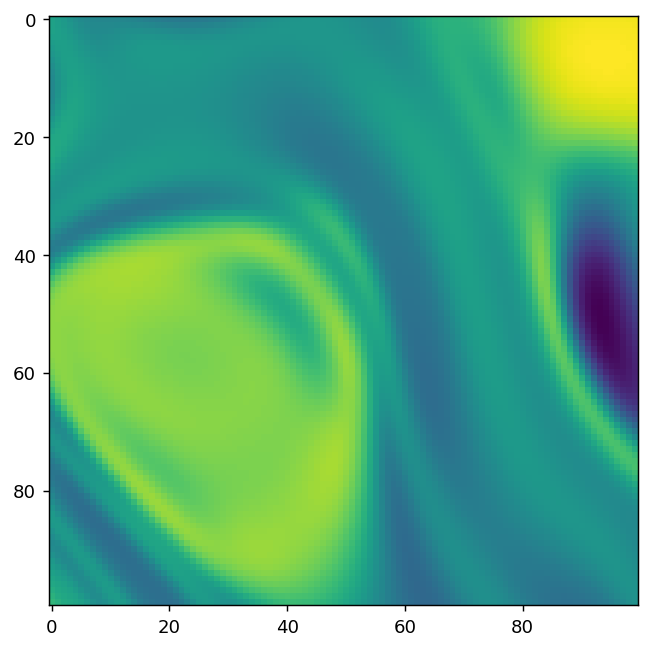

In [56]:
fig=plt.figure(figsize=(6,6), dpi = 130, facecolor='w', edgecolor='k')
plt.imshow(y_pred.reshape(100,100))
plt.show()

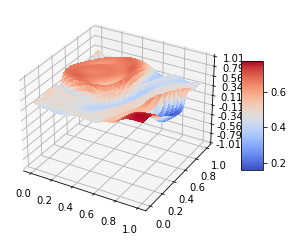

In [58]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
from matplotlib import cm
from matplotlib.ticker import LinearLocator

# Make data.
X = np.linspace(0, 1, n)
Y = np.linspace(0, 1, n)
X, Y = np.meshgrid(X, Y)
Z = y_pred.reshape(100,100)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()